# Support Vector Machines

Si miran la documentación hay tres implementaciones en Scikit-Learn dentro del módulo SVM:

Están implementadas sobre [dos bibliotecas diferentes](https://www.tutorialspoint.com/scikit_learn/scikit_learn_support_vector_machines.htm) (liblinear y libsvm) que les dan algunas características particulares.

*   **Linear Support Vector Classification** [(LinearSVC)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html): Más flexibilidad en la elección de penalizaciones y funciones de pérdida. Escala mejor en data sets más grandes, no soporta kernels (porque se asume que es lineal) y no se puede acceder a algunos atributos, como los vectores de soporte.
*    **C-Support Vector Classification** [(SVC)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html): Admite kernels (si se usa kernel='linear' es similar a LinearSVC) y acceso a más atributos que LinearSVC, puede ser impráctico para data sets grandes.

*    **Nu-Support Vector Classification** [(NuSVC)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn-svm-nusvc): Similar a  SVC pero usa un parámetro para controlar el número de vectores de soporte.

No vamos a hacer mucha distinción en los primeros ejemplos, pero a medida que vayamos avanzando vamos a usar SVC.


## Preparación

In [ ]:
# las funciones de siempre, las pongo todas al principio así queda más claro el código de abajo

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    '''
    Para plotear las fronteras de decisión de un svc
    '''
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

## Clasificador de margen duro

Dijimos que un SVM busca la separación que se mantiene lo más alejada posible de las instancias de entrenamiento más cercanas, "busca la calle más ancha entre los datos", añadir más instancias entrenamiento fuera "de la calle" no afecta la frontera, ya que está totalmente determinada por las instancias situadas en el borde.
Estas instancias se denominan vectores de soporte (support vectors). Si somos estrictos en esta separación, o sea, si no permitimos ningún punto dentro de esta "calle" y estamos buscando una separación perfecta entre las clases estamos hablando de un **margen duro**.

La implementación de Scikit-Learn maneja esto a través del hiperparámetro *C* valores más altos penalizan mas fuerte los puntos que violen este margen, endureciéndolo. Hagamos una clasificación sobre Iris con un *C* alto para ver el efecto.

El procedimiento es igual que siempre, importamos el clasificador (SVC) y hacemos un .fit:


In [ ]:
# imports e iris
# Código adaptado del Géron

import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.pipeline import Pipeline

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

# nos quedamos solo con dos especies
# para usarlo en el SVM
setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

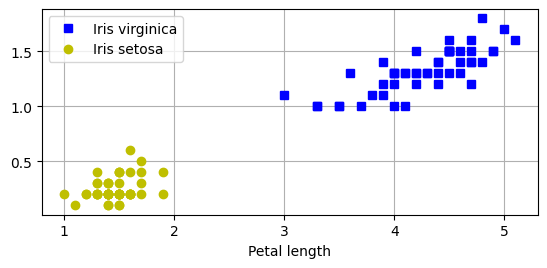

In [ ]:
#Puntos
#y==1 virgínica
#y==0 setosa
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length")
plt.legend(loc="upper left")
plt.gca().set_aspect("equal")
plt.grid()

plt.show()

In [ ]:
'''
usamos un SVC con kernel lineal, es por simplicidad ya que la función que grafica las fronteras usa los atributos de vectores de soporte
Discusión de si un SVC con kernel lineal es lo mismo que un linearSVC
https://stackoverflow.com/questions/33843981/under-what-parameters-are-svc-and-linearsvc-in-scikit-learn-equivalent/33844092#33844092
'''

svm_clf = SVC(kernel="linear", C=1e120)
svm_clf.fit(X, y)

#Prueben hacer lo mismo con este C pero usando versicolor y virgínica
#que les parece que pasa?

SVC(C=1e+120, kernel='linear')

Ye tenemos nuestro modelo ajustado, grafiquemos la frontera de decisión (usando la función plot_svc_decision_boundary definida más arriba) junto con los puntos del dataset:

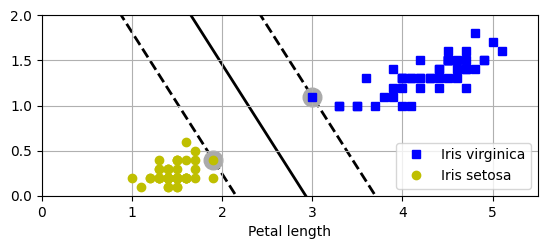

In [ ]:
#fronteras de decisión del svm_clf
plot_svc_decision_boundary(svm_clf, 0, 5.5)
#Puntos
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length")
plt.legend(loc="lower right")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.show()

Los puntos resaltados son los vectores de soporte que usó el SVM para definir la región, fíjense como efectivamente no hay ningún punto dentro de la región y los datos están perfectamente clasificados.

Ahora veamos un detalle, los SVM son sensibles a la escala de las características

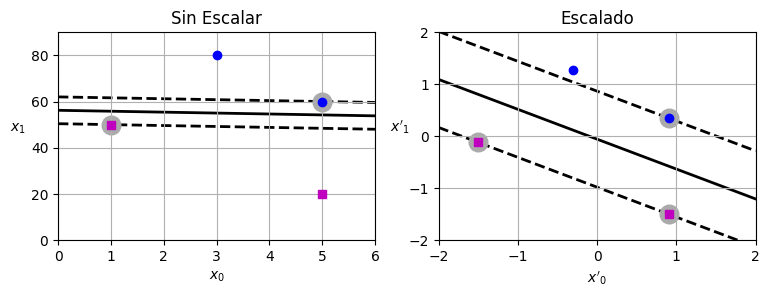

In [ ]:
'''
Muestra de que el svm es sensible a la escala
'''

from sklearn.preprocessing import StandardScaler

#datos de mentira
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])

#clasificador con un marquen duro
svm_clf = SVC(kernel="linear", C=1e120).fit(Xs, ys)

'''
Se estandarizan las características eliminando la media y escalando a la varianza unitaria
La puntuación estándar de una muestra x se calcula como:
z = (x - u) / s

https://qu4nt.github.io/sklearn-doc-es/modules/preprocessing.html#preprocessing-scaler
'''

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf_scaled = SVC(kernel="linear", C=1e120).fit(X_scaled, ys)

#graficamos
plt.figure(figsize=(9, 2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$    ", rotation=0)
plt.title("Sin Escalar")
plt.axis([0, 6, 0, 90])
plt.grid()

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf_scaled, -2, 2)
plt.xlabel("$x'_0$")
plt.ylabel("$x'_1$  ", rotation=0)
plt.title("Escalado")
plt.axis([-2, 2, -2, 2])
plt.grid()

plt.show()

En el gráfico de la izquierda la escala vertical es mucho más grande que la horizontal, entonces la calle más ancha es casi horizontal
Si se hace un escalado, por ejemplo con StandardScaler, la frontera queda mucho mejor.

Cuando usemos kernels esto va a ser mandatorio

## Clasificador de margen suave

Usar un clasificador de margen duro solamente funciona si los datos son linealmente separables y también es muy sensible a outliers

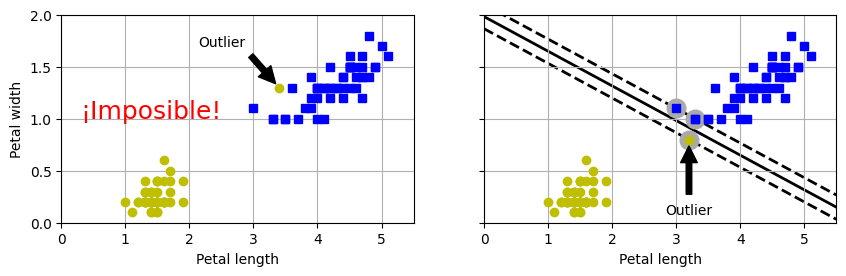

In [ ]:
#Traemos todo de nuevo, prefiero que las celdas sean los más independientes posibles

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# Le agregamos un par de outliers
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=1e120)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "¡Imposible!", color="red", fontsize=18)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.annotate(
    "Outlier",
    xy=(X_outliers[0][0], X_outliers[0][1]),
    xytext=(2.5, 1.7),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length")
plt.annotate(
    "Outlier",
    xy=(X_outliers[1][0], X_outliers[1][1]),
    xytext=(3.2, 0.08),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.show()


El gráfico de la izquierda no es linealmente separable y no podria usarse un margen duro, y el de la derecha está muy influido por el outlier llevando a una clasificación que no pareceria generalizar bien.

Hay que flexibilizar un poco el modelo, buscar un buen balance entre "mantener la calle lo más ancha posible" y limitar los puntos que pueden caer fuera de los límites.

Esto se llama clasificación de margen suave, entre los hiperparámetros que se pueden especificar cuando sea crea el modelo SVM está el hiperparámetro de regularización *C*.

Achicar el C hace la calle más ancha, reduciendo el riesgo de sobreajuste al permitir más violaciones al margen, pero si es muy chico puede terminar en un subajuste (underfitting).

Aumentar el C hace lo contrario, endurece el margen haciendo "la calle más angosta" y por ende permitiendo menos puntos dentro del margen

Es uno de los parámetros a optimizar.

Veamos como varia el margen al modificar este valor


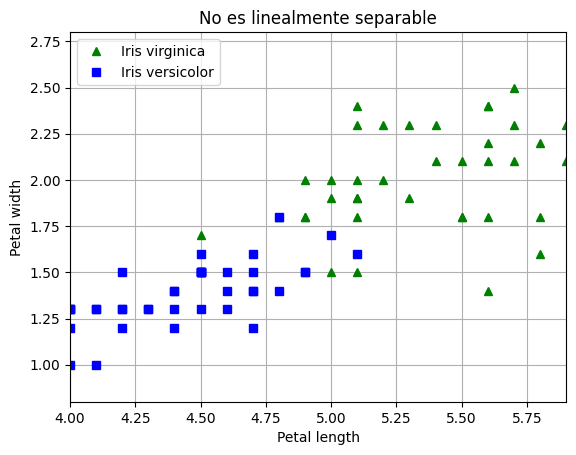

In [ ]:
iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)  # Iris virginica

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plt.axis([4, 5.9, 0.8, 2.8])
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title("No es linealmente separable")
plt.grid()

In [ ]:
 # hagamos cuatro clasificadores variando el C

svm_clf_0 = SVC(kernel="linear", C=0.05)
svm_clf_0.fit(X, y)

svm_clf_1 = SVC(kernel="linear", C=1)
svm_clf_1.fit(X, y)

svm_clf_2 = SVC(kernel="linear", C=40)
svm_clf_2.fit(X, y)

svm_clf_3 = SVC(kernel="linear", C=50000)
svm_clf_3.fit(X, y)

SVC(C=50000, kernel='linear')

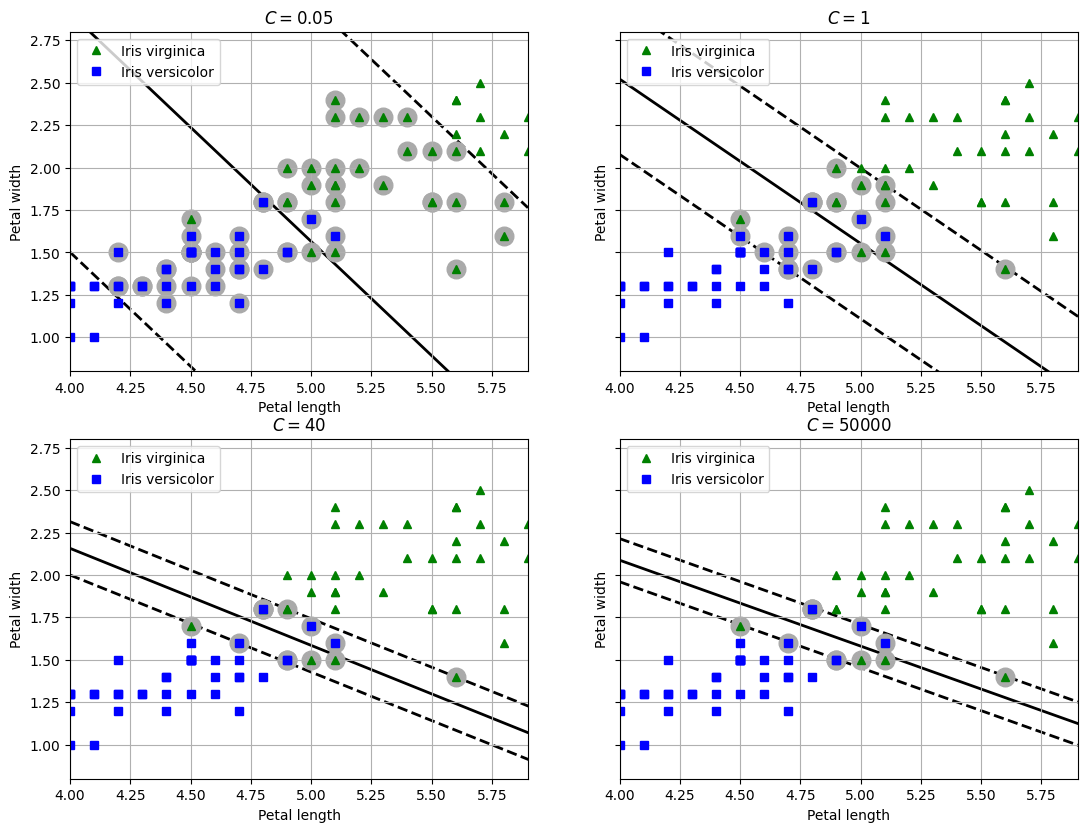

In [ ]:
# Graficos
fig, axes = plt.subplots(2,2, figsize=(13, 9.7), sharey=True)
plt.sca(axes[0,0])
plot_svc_decision_boundary(svm_clf_0, 4, 5.9)
#Puntos
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plt.axis([4, 5.9, 0.8, 2.8])
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf_0.C}$")
plt.grid()

plt.sca(axes[0,1])
plot_svc_decision_boundary(svm_clf_1, 4, 5.99)
#Puntos
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plt.axis([4, 5.9, 0.8, 2.8])
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf_1.C}$")
plt.grid()

plt.sca(axes[1,0])
plot_svc_decision_boundary(svm_clf_2, 4, 5.99)
#Puntos
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plt.axis([4, 5.9, 0.8, 2.8])
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf_2.C}$")
plt.grid()

plt.sca(axes[1,1])
plot_svc_decision_boundary(svm_clf_3, 4, 5.99)
#Puntos
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plt.axis([4, 5.9, 0.8, 2.8])
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf_3.C}$")
plt.grid()


plt.show()

## Pensemos en más dimensiones

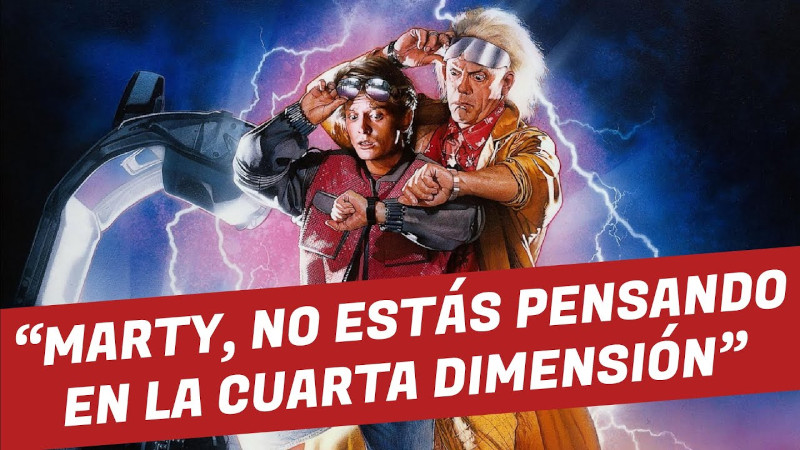

Generalmente los ejemplos que estuvieron viendo durante el curso son de conjuntos de datos más bien pequeños y vemos ejemplos de gráficos en dos dimensiones.
Esto es por una cuestión de tiempo de exposición y recursos computacionales, pero sobre todo didáctica, una representación visual ayuda a entender que hacen las técnicas y busca desarrollar al menos una intuición de como trabajan con conjuntos de datos más grandes o de dimensionalidad más alta.
Hagamos un pequeño paréntesis para hablar de este tema usando Iris.


In [ ]:
#vamos a usar esta libreria para graficar en 3D, ya que estamos usamos iris de ahí

#deberia estar instalada en google colab, sino se instala con
#!pip install plotly==4.14.3

import plotly.express as px
df = px.data.iris()
df

,sepal_length,sepal_width,petal_length,petal_width,species,species_id
0,5.1,3.5,1.4,0.2,setosa,1
1,4.9,3.0,1.4,0.2,setosa,1
2,4.7,3.2,1.3,0.2,setosa,1
3,4.6,3.1,1.5,0.2,setosa,1
4,5.0,3.6,1.4,0.2,setosa,1
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,3
146,6.3,2.5,5.0,1.9,virginica,3
147,6.5,3.0,5.2,2.0,virginica,3
148,6.2,3.4,5.4,2.3,virginica,3


Cada flor tiene cuatro características numéricas que podemos usar en nuestros análisis, usando estas características cada punto vive en un espacio de cuatro dimensiones.

Se complica graficarlos, pero al menos podríamos elegir tres características y ver las flores en un gráfico de tres dimensiones. Por ejemplo tomemos el ancho y el largo del pétalo junto con el ancho del sépalo


In [ ]:
fig = px.scatter_3d(df, x='petal_length', y='petal_width', z='sepal_width',
              color='species')
fig.show()

#prueden probar cambiar los atriburtos a plotear

Se ve como setosa es claramente distinguible de las otras dos especies, quedemonos con esa y con versicolor.

In [ ]:
#nos quedamos solo con setosa y versicolor
df_0 = df[(df['species']=='setosa') | (df['species']=='versicolor')]
fig = px.scatter_3d(df_0, x='petal_length', y='petal_width', z='sepal_width',
              color='species')
fig.show()


Estuvimos viendo que los SVM (en realidad cualquier clasificador lineal) hacen una frontera para dividir los datos, ¿cómo se veria esta frontera con estos puntos?

Hagamos un SVM y veamos...




In [ ]:
import plotly.graph_objs as go
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler

X = df_0[['petal_length', 'petal_width', 'sepal_width']]

# Escalar características para SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Entrenar el modelo SVM
model = svm.SVC(kernel='linear')
model.fit(X_scaled, df_0['species_id'])

# Obtener coeficientes del hiperplano
coef = model.coef_[0]
intercept = model.intercept_[0]

# Función para el hiperplano de decisión
def decision_surface(x, y):
    return (-coef[0] * x - coef[1] * y - intercept) / coef[2]

# Crear figura con scatter plot
fig = px.scatter_3d(df_0, x='petal_length', y='petal_width', z='sepal_width', color='species')

# Definir malla de puntos para la superficie
x_range = np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), 50)
y_range = np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max(), 50)
xx, yy = np.meshgrid(x_range, y_range)
zz = decision_surface(xx, yy)

# Invertir la transformación para desescalar la superficie
xx_inv = xx
yy_inv = yy
zz_inv = zz
inv_transformed = scaler.inverse_transform(np.column_stack((xx_inv.ravel(), yy_inv.ravel(), zz_inv.ravel())))
xx_inv = inv_transformed[:, 0].reshape(xx.shape)
yy_inv = inv_transformed[:, 1].reshape(yy.shape)
zz_inv = inv_transformed[:, 2].reshape(zz.shape)

# Agregar superficie que representa el hiperplano de decisión
fig.add_trace(go.Surface(x=xx_inv, y=yy_inv, z=zz_inv, opacity=0.5, showscale=False))

fig.show()


Podemos usar SVM en cuantas dimensiones tengan los datos, pero no siempre podemos VER el resultado.
Por eso vamos a tener que confiar en el resultado de métricas

In [ ]:
from sklearn import metrics
t = df_0['species_id']

metrics.accuracy_score(model.predict(X_scaled), t)


1.0

## Clasificaciones no lineales

Los SVM pueden funcionar eficientemente para muchos casos, pero hay conjuntos de datos que no son linealmente separables
Una forma de trabajar con esto es agregar más características a los puntos (como hicieron con regresión polinomial) o sea, aumentar la dimensionalidad de los datos
En algunos casos esto puede resultar en un conjunto de datos linealmente separable

Hagamos un ejemplo de juguete para mostrar esto...


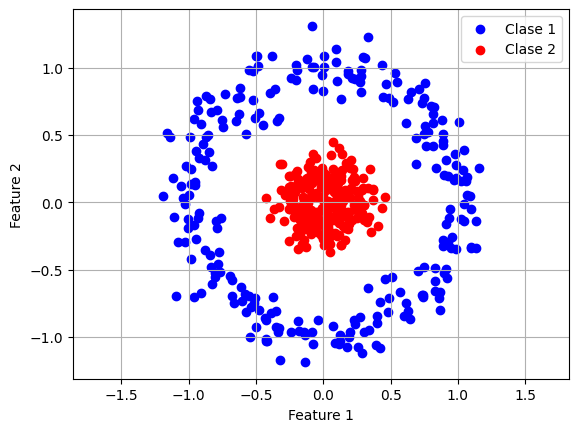

In [ ]:
from sklearn.datasets import make_circles

# Genera dos círculos concentricos
X_circ, t = make_circles(n_samples=500, noise=0.1, factor=0.2, random_state=42)

# Separa los puntos de los dos círculos
circle1 = X_circ[t == 0]
circle2 = X_circ[t == 1]

# Crea el gráfico
plt.scatter(circle1[:, 0], circle1[:, 1], color='blue', label='Clase 1')
plt.scatter(circle2[:, 0], circle2[:, 1], color='red', label='Clase 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


Obviamente un SVM mucho no puede hacer, por más que toquemos el C

In [ ]:
model = svm.SVC(kernel='linear', C=0.00011)
model.fit(X_circ, t)
metrics.accuracy_score(model.predict(X_circ), t)

0.682

A simple vista ya se ve que estas dos clases no son linealmente separables, inventemos una nueva variable usando los valores de cada punto(*):

 $$(x, y) ⇒ (x, y, x^2+y^2) $$

 Cada uno de estos nuevos puntos *viven* en un espacio de tres dimensiones

 (*)si, obvio que está ASTUTAMENTE creada, es para introducir la idea que los mismos puntos en otro espacio pueden ser separables

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

x = np.concatenate((circle1[:, 0], circle2[:, 0]))
y = np.concatenate((circle1[:, 1], circle2[:, 1]))

# ACÁ LO IMPORTANTE
# Creamos la variable z usando x e y
z = x**2 + y**2

color_1 = np.repeat('blue', len(circle1))
color_2 = np.repeat('red', len(circle2))
color = np.concatenate((color_1, color_2))

data = pd.DataFrame({'x': x, 'y': y, 'z': z, 'color':color})

# Coeficientes del hiperplano
# no es el de un SVM,solamente para mostrar como se pueden separar
a, b, c, d = 0, 0, 1, -0.4
# Crea una malla para el plano
xx, yy = np.meshgrid(np.linspace(x.min(),x.max(), 10),
                     np.linspace(y.min(), y.max(), 10))
zz = (-a * xx - b * yy - d) / c

# Crea el gráfico 3D
fig = px.scatter_3d(data, x='x', y='y', z=z, color=color)
# Si se quiere mostrar el hiperplano
#fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

#cámara cenital, solo para golpe de efecto...
camera_params = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=0, z=1.5)
)
fig.update_layout(scene_camera=camera_params)
fig.show()

Veamos como clasifica el SVM con esta nueva variable

In [ ]:
# X_circ eran los puntos (x,y) datos por el make circles, y t eran las etiquetas

col_names = ['x', 'y']
X_new = pd.DataFrame(X_circ, columns=col_names)
X_new['z'] = X_new['x']**2 + X_new['y']**2

model = svm.SVC(kernel='linear')
model.fit(X_new, t)
metrics.accuracy_score(model.predict(X_new), t)

1.0

Esa nueva característica se hizo a ojo, pero estamos en aprendizaje automático, la idea es que la que la labure sea la computadora! una opcion que ya vieron es usar un [PolynomialFeatures(...)](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

Que genera todas las posibles combinaciones polinomiales con los features, con un grado menor o igual al especificado. Por ejemplo, si tenemos puntos (x, y) la salida de un polynomial features de grado dos es = $(1, x, y,x ^2, xy, y^2 )$

---
**NOTA:** Cuando mencionemos al *espacio de características* (feature space) nos referimos al espacio donde se mueven nuestros datos, en el caso de los círculos es un espacio dos-dimensional.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X = np.array([[2, 3]])
poly.fit_transform(X)

array([[1., 2., 3., 4., 6., 9.]])

Usemos esto con un SVM y las lunas

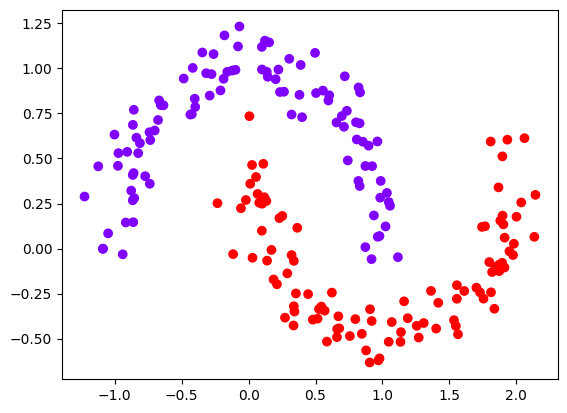

In [ ]:
from sklearn.datasets import make_moons
X_moons, t = make_moons(n_samples=200, noise=0.1, random_state=42)

plt.scatter(X_moons[:,0], X_moons[:,1], c=t+5, cmap='rainbow')
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

#miren ese C, es un margen duro!

model = Pipeline([('scaler', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=7)),
                  ('SVM', svm.SVC(kernel='linear', C=1e120))
                  ])
_ = model.fit(X_moons, t)

In [ ]:
metrics.accuracy_score(model.predict(X_moons), t)

1.0

(Si tienen que repasar el pipeline es muy buena la [documentación](https://scikit-learn.org/stable/modules/compose.html) y tiene unos ejemplos interesantes, miren el de GridSearchCV, y tambien puede mirar [acá](https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/))

In [ ]:
print('El dataset original está en {} dimensiones.'.format(X_moons.shape[1]))

Xp = model['poly'].transform(X_moons)
print('El dataset transformado está en {} dimensiones.'.format(Xp.shape[1]))

print('***')

El dataset original está en 2 dimensiones.
El dataset transformado está en 36 dimensiones.
***


Podemos hacer un lindo gráfico usando el método [decision_function](https://www.geeksforgeeks.org/ml-decision-function/) que para cada punto se fija de que lado de la frontera de clasificación quedó, que tan alejado está y que tanta "confianza" tiene en la predicción.

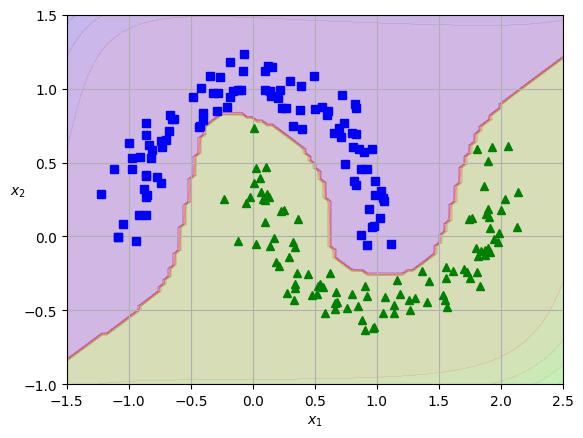

In [ ]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(model, [-1.5, 2.5, -1, 1.5])
plot_dataset(X_moons, t, [-1.5, 2.5, -1, 1.5])

plt.show()

## Kernels

Agregar características polinomiales es fácil de implementar y puede funcionar con todo tipo de algoritmos (no solo con SVM).

Pero con un grado bajo esta táctica no puede tratar con datos muy complejos e incrementarlo demasiado aumenta mucho la cantidad de características haciendo el modelo muy lento.

Afortunadamente, al trabajar con SVMs, se puede usar una técnica casi milagrosa, llamada el truco del kernel con la que se obtiene el mismo resultado que agregar muchas características polinomiales (incluso potencialmente infinitas) sin tener que agregarlas (!!!), por lo que no tenemos una explosión combinatoria en el número de características

(Citando a [link](https://aprendeia.com/kernel-maquinas-vectores-de-soporte-clasificacion-regresion/))

"Los kernel permiten operar en un espacio de características implícito y de alta dimensión sin tener que calcular nunca las coordenadas de los datos en ese espacio, sino simplemente calculando los productos internos entre las imágenes de todos los pares de datos **en el espacio de características**. Esta operación es a menudo más barata que el cálculo explícito de las coordenadas."

En la sección *Kernelized SVMs* del capítulo 5 del Géron y en este [Link](https://www.quora.com/What-are-kernels-in-machine-learning-and-SVM-and-why-do-we-need-them/answer/Lili-Jiang?srid=oOgT) tienen una aproximación sencilla a la idea. Y si quieren ver a fondo la matemática (e incluso como definir sus propios kernels) se puede recurrir al capitúlo 6 del [Bishop](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)

Ya vimos como trabajaba el kernel lineal, veamos dos más.

### Kernel Polinomial

En el kernel polinomial el principal hiperparámetro es el grado, el otro es coef0 que es el término independiente del polinomio

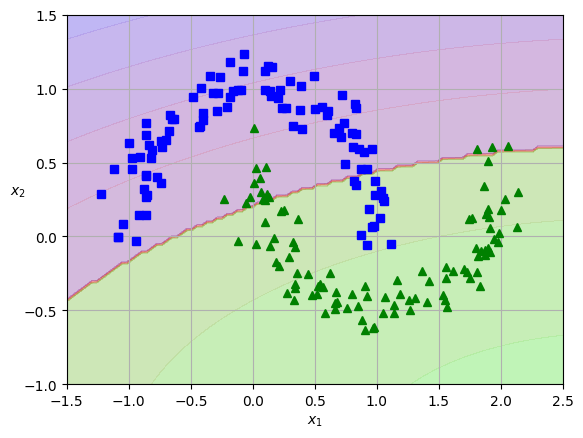

Accuracy: 0.85


In [ ]:
X_moons, t = make_moons(n_samples=200, noise=0.1, random_state=42)

model_poly = Pipeline([('scaler', StandardScaler()),
                       ('SVM_poly', SVC(kernel='poly', degree=2, coef0=10, C=1.0))
                      ])
_ = model_poly.fit(X_moons, t)

plot_predictions(model_poly, [-1.5, 2.5, -1, 1.5])
plot_dataset(X_moons, t, [-1.5, 2.5, -1, 1.5])

plt.show()

print("Accuracy: {}".format(metrics.accuracy_score(model_poly.predict(X_moons), t)))

Veamos un poco como cambia la frontera de decisión al cambiar los hiperparámetros

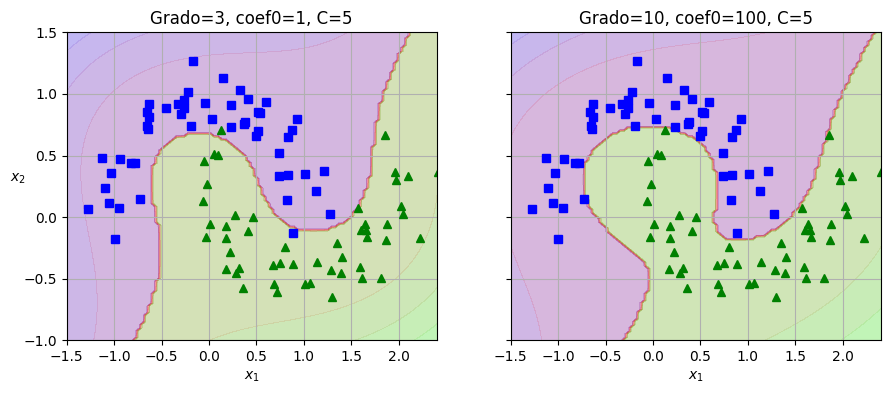

Accuracy 0: 0.98
Accuracy 1: 1.0


In [ ]:
# Géron
from sklearn.pipeline import make_pipeline

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X, y)

poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("Grado=3, coef0=1, C=5")

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("Grado=10, coef0=100, C=5")
plt.ylabel("")

plt.show()

#Está claro que estamos mostrando el valor de accuracy para complementar las imágenes, no?
#para ver como se comporta realmente en datos no vistos hay que separa en train, test, etcetc...

print("Accuracy 0: {}".format(metrics.accuracy_score(poly_kernel_svm_clf.predict(X), y)))
print("Accuracy 1: {}".format(metrics.accuracy_score(poly100_kernel_svm_clf.predict(X), y)))

### Kernel RBF


[Radial Basis Function (RBF) kernel](https://towardsdatascience.com/radial-basis-function-rbf-kernel-the-go-to-kernel-acf0d22c798a): Para dos puntos calcula la *similaridad* o que tan cerca están uno del otro, el hiperparámetro *gamma* define que tanta influencia tiene un punto, cuanto más grande mas cerca tienen que estar los otros para ser afectados. Valores más chicos van a producir fronteras menos complejas (menos suaves).


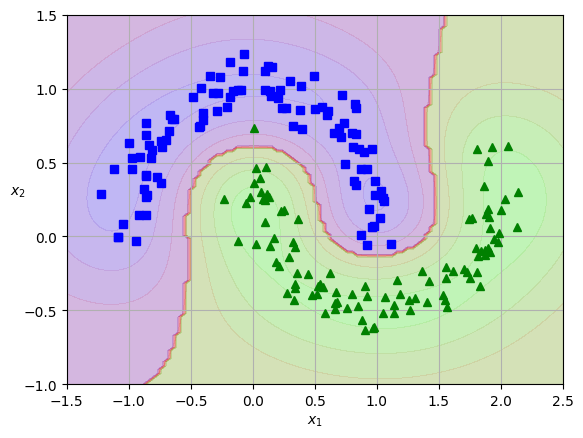

Accuracy: 0.995


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

X_moons, t = make_moons(n_samples=200, noise=0.1, random_state=42)

model_rbf = Pipeline([('scaler', StandardScaler()),
                      ('SVM_RBF', SVC(kernel='rbf', C=1, gamma=1))
                    ])
_ = model_rbf.fit(X_moons, t)

plot_predictions(model_rbf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X_moons, t, [-1.5, 2.5, -1, 1.5])

plt.show()

print("Accuracy: {}".format(metrics.accuracy_score(model_rbf.predict(X_moons), t)))



Veamos un poco como cambia la frontera de decisión al cambiar los hiperparámetros

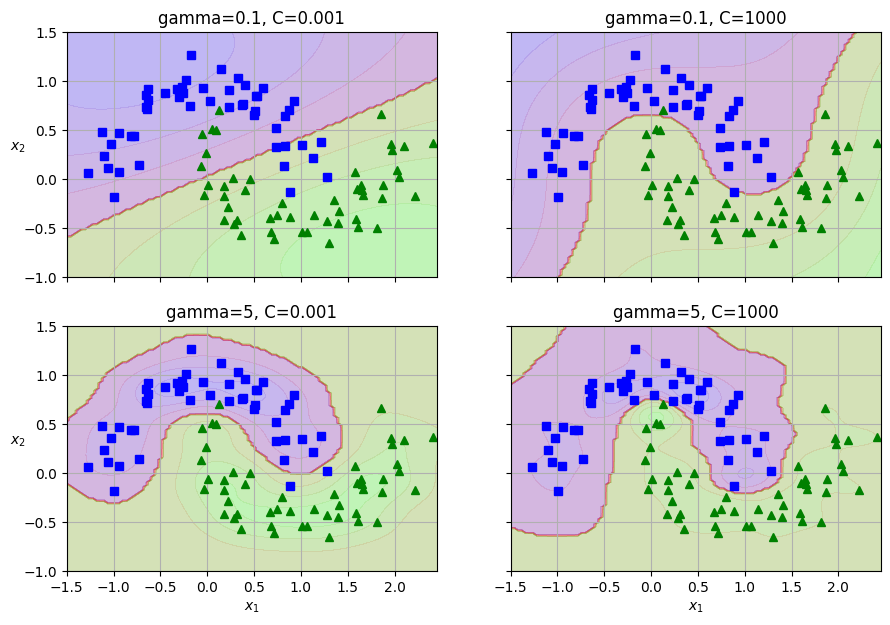

In [ ]:
#Géron
from sklearn.svm import SVC

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

rbf_kernel_svm_clf = make_pipeline(StandardScaler(),
                                   SVC(kernel="rbf", gamma=5, C=0.001))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(f"gamma={gamma}, C={C}")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

**EXTRA:** Si bien SVM de forma nativa no acepta la clasificación multiclase se puede usar igualmente, usa [One-Vs-One](https://scikit-learn.org/stable/modules/multiclass.html). Mostrémoslo y de paso compararemos como se ven las fronteras con los distintos métodos que estuvimos viendo.

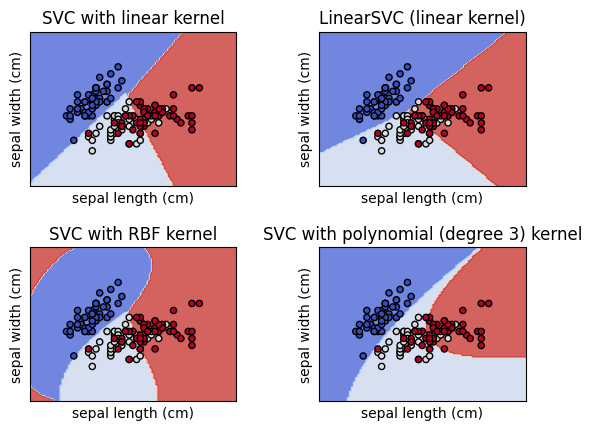

In [ ]:
#Sacado de https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html#plot-different-svm-classifiers-in-the-iris-dataset

import matplotlib.pyplot as plt

from sklearn import datasets, svm
from sklearn.inspection import DecisionBoundaryDisplay

# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()